## Dependencies 

To view the visualizations below, you may need to install holoviews:

```
!pip install holoviews
!pip install --upgrade bokeh
```

## Introduction
This notebook shows how to use the Windows Defender ATP APIs. It defines a Python wrapper for calling the API 
and several Jupyter magics to make it easy to access WDATP information. While the APIs are documented and supported,
the wrapper in this notebook is a sample and is not an official programming interface.

Author: [@JohnLaTwC] (https://twitter.com/JohnLaTwC)

## Links to API documentation

[APIs] (https://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-atp/use-apis)

[Query] (https://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-atp/run-advanced-query-api)

[Alert] (https://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-atp/alerts-windows-defender-advanced-threat-protection-new)

[File] (https://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-atp/files-windows-defender-advanced-threat-protection-new)

[Machine] (https://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-atp/machine-windows-defender-advanced-threat-protection-new)

[User] (https://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-atp/user-windows-defender-advanced-threat-protection-new)

[Machine Action] (https://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-atp/machineaction-windows-defender-advanced-threat-protection-new)

[Domain] (https://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-atp/get-domain-related-alerts-windows-defender-advanced-threat-protection-new)

[IPs] (https://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-atp/get-ip-related-alerts-windows-defender-advanced-threat-protection-new)

[OData examples] (https://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-atp/exposed-apis-odata-samples)

## Initializing secrets

When your app is registered to call the WDATP APIs you need to pass the credentials in to this sample. 

Simply edit or replace this `get_secret` function to return the proper values.

In [4]:
def get_secret(secret_name):
    return {'WDATP_DEMO_appId':'<<insert secret>>',
            'WDATP_DEMO_appSecret':'<<insert secret>>',
            'WDATP_DEMO_tenantId':'<<insert secret>>',
            'VT_API_KEY':'<<optional VirusTotal API Key>>'}[secret_name]

In [5]:
## e.g. custom way to access secrets
def get_secret(secret_name):
    import os
    return os.environ.get(secret_name)

In [ ]:
appId = get_secret('WDATP_DEMO_appId')
appSecret = get_secret('WDATP_DEMO_appSecret') 
tenantId = get_secret('WDATP_DEMO_tenantId')
vt_api_key = get_secret('VT_API_KEY')
print("If your secrets were initialized properly you should see your tenant id.\nTenant Id: %s " % tenantId)

## Getting Started
All the API Wrapper code is below. Activate it by clicking in the cell and hitting Shift+Enter

In [7]:
# -------------------------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License. 
# --------------------------------------------------------------------------

# Author: @JohnLaTwC

## https://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-atp/run-advanced-query-api

import json
import urllib.request
import urllib.parse
import pandas as pd
import re
from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)

SPLIT_DELIMS = '[\[\] ;\n\t|,xX"\']'
@register_line_cell_magic
def hash(line, cell=None):
    if cell is None:
        return line
    else:    
        results = []
        for f in re.split(SPLIT_DELIMS,cell):
            p = re.compile('^[a-f0-9]{32}$'
                           '|^[a-f0-9]{40}$'
                           '|^[a-f0-9]{64}$'
                           ,re.IGNORECASE)
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        
        return results           

# We delete these to avoid name conflicts for automagic to work
del hash 

@register_line_cell_magic
def vthash(line, cell=None):
    if cell is None:
        return wdatp_api.vtresults([line])
    else:    
        results = []
        for f in re.split(SPLIT_DELIMS,cell):
            p = re.compile('^[a-f0-9]{32}$'
                           '|^[a-f0-9]{40}$'
                           '|^[a-f0-9]{64}$'
                           ,re.IGNORECASE)
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        
        if len(results) == 0:
            return
        return wdatp_api.vtresults(results)
           

# We delete these to avoid name conflicts for automagic to work
del vthash 

@register_line_cell_magic
def wdatp_file(line, cell=None):
    if cell is None:
        return wdatp_api.files(filehash=line)
    else:    
        results = []
        for f in re.split(SPLIT_DELIMS,cell):
            p = re.compile('^[a-f0-9]{40}$',re.IGNORECASE)
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        
        if len(results) == 0:
            return
        dfs = []
        for filehash in results:
            dfs.append(wdatp_api.files(filehash=filehash))
        import pandas as pd
        return pd.concat(dfs)
            
# Delete these to avoid name conflicts for automagic to work
del wdatp_file

@register_line_cell_magic
def wdatp_machine(line, cell=None):
    if cell is None:
        if re.match('^[a-f0-9]{40}$', line):
            return wdatp_api.machines(machineid=line)
        else:
            return wdatp_api.machines(filterstr="$filter=ComputerDnsName eq '%s'" % line)
    else:    
        results = []
        for f in re.split(SPLIT_DELIMS,cell):
            p = re.compile('^[a-f0-9]{40}$',re.IGNORECASE)
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        
        dfs = []

        # if we did not get any machine Ids, treat them as ComputerDnsNames
        if len(results) == 0:
            results = cell.split('\n')
            for hostname in results:
                dfs.append(wdatp_api.machines(filterstr="$filter=ComputerDnsName eq '%s'" % hostname))
        else:
            for machine_id in results:
                dfs.append(wdatp_api.machines(machineid=machine_id))
        import pandas as pd
        return pd.concat(dfs)
            
# Delete these to avoid name conflicts for automagic to work
del wdatp_machine 

@register_line_cell_magic
def wdatp_alert(line, cell=None):
    if cell is None:
        return wdatp_api.alerts(alertid=line)
    else:    
        results = []
        for f in re.split(SPLIT_DELIMS,cell):
            p = re.compile('^[\d]{18}_\-*[\d]{5,16}$',re.IGNORECASE)
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        if len(results) == 0:
            return
        dfs = []
        for alert_id in results:
            dfs.append(wdatp_api.alerts(alertid=alert_id))
        import pandas as pd
        return pd.concat(dfs)

# Delete these to avoid name conflicts for automagic to work
del wdatp_alert 

@register_line_cell_magic
def wdatp_ip(line, cell=None):
    if cell is None:
        return wdatp_api.ips(ip=line)
    else:    
        results = []
        for f in re.split(SPLIT_DELIMS,cell):
            p = re.compile('^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$')
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        if len(results) == 0:
            return
        dfs = []
        for ip in results:
            dfs.append(wdatp_api.ips(ip=ip))
        import pandas as pd
        return pd.concat(dfs)
            
# Delete these to avoid name conflicts for automagic to work
del wdatp_ip 
        
@register_line_cell_magic
def wdatp_action(line, cell=None):
    if cell is None:
        return wdatp_api.ips(ip=line)
    else:    
        results = []
        for f in re.split(SPLIT_DELIMS,cell):
            p = re.compile('^[a-f0-9]{8}'
                       '-[a-f0-9]{4}'
                       '-[a-f0-9]{4}'
                       '-[a-f0-9]{4}'
                       '-[a-f0-9]{12}$'
                       ,re.IGNORECASE)
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        if len(results) == 0:
            return
        dfs = []
        for action in results:
            dfs.append(wdatp_api.machine_actions(actionid = action))
        import pandas as pd
        return pd.concat(dfs)
            
# Delete these to avoid name conflicts for automagic to work
del wdatp_action
    
class WDATP:
    def __init__(self, tenantId, appId, appSecret, vt_api_key=None, fUsePandas=True, api_root="https://api.securitycenter.windows.com"):
        url = "https://login.windows.net/%s/oauth2/token" % (tenantId)

        self.fDebug = False
        resourceAppIdUri = 'https://api.securitycenter.windows.com'

        body = {
            'resource' : resourceAppIdUri,
            'client_id' : appId,
            'client_secret' : appSecret,
            'grant_type' : 'client_credentials'
        }

        ## authenticate and obtain AAD Token for future calls
        data = urllib.parse.urlencode(body).encode("utf-8")
        req = urllib.request.Request(url, data)
        response = urllib.request.urlopen(req)
        jsonResponse = json.loads(response.read())
        self.aadToken = jsonResponse["access_token"]
        self.headers = { 
            'Content-Type' : 'application/json',
            'Accept' : 'application/json',
            'Authorization' : "Bearer " + self.aadToken
        }
        self.fUsePandas = fUsePandas # use pandas DataFrame for collections of objects, else return a list
        self.api_root = api_root
        self.vt_api_key = vt_api_key
        if len(self.aadToken) > 0:
            print("Connected.")
    
    def set_output_type(self, fUsePandas=True):
        self.fUsePandas = fUsePandas    

    def set_debug_output(self, fDebug=True):
        self.fDebug = fDebug    
        
    def __validate_arguments(self,args, valid_params):
        if len(args) == 0:
            raise ValueError ('argument must be one of %s' % str(list(valid_params.keys())))
        elif len(args) > 1:
            raise ValueError ('only one id can be used at a time')
        else:
            selector = next(iter(args))
            selector_value= next(iter(args.values()))
            if selector not in list(valid_params.keys()):
                raise ValueError ('argument must be one of %s' % str(list(valid_params.keys())))
        return (selector, selector_value)

    def __make_request(self,url, params=None):
 
        if self.fDebug:
            print(url)
        req = urllib.request.Request(url, headers=self.headers)
        try:
            response = urllib.request.urlopen(req)
        except urllib.error.HTTPError as e:
            raise e
                
        jsonResponse = json.loads(response.read())
        if type(jsonResponse) == int:
            if self.fUsePandas:
                return pd.DataFrame([jsonResponse])
            else:
                return jsonResponse
        if 'value' in jsonResponse:
            res = jsonResponse["value"]
        else:
            res = jsonResponse     
        if self.fUsePandas:
            return pd.io.json.json_normalize(res)
        return res

    def __prepare_param_dict_from_filter_str(self, filterstr):
        get_params = {}
        for filter_param in re.split("[\?\&]+", filterstr):
            if len(filter_param)> 0:
                attr = filter_param.split('=')[0]
                val  = filter_param.split('=')[1]
                get_params[attr]= val
        return get_params
    
    def alerts(self, **kwargs):
        alert_url = self.api_root + "/api/alerts"
        get_params = None
        
        valid_params = {
            'filterstr' : alert_url + '?%s',
            'alertid' : alert_url + '/%s',
            'userid'    : self.api_root + '/api/users/%s/alerts',
            'ip'        : self.api_root + '/api/ips/%s/alerts',
            'machineid'   : self.api_root + '/api/machines/%s/alerts',
            'filesha1'  : self.api_root + '/api/files/%s/alerts', 
            'domain'    : self.api_root + '/api/domains/%s/alerts' 
        }
        (selector, selector_value) = self.__validate_arguments(kwargs, valid_params)
        
        if selector == 'filterstr':
            get_params = self.__prepare_param_dict_from_filter_str(selector_value)
            if get_params is not None:
                url = valid_params[selector] % urllib.parse.urlencode(get_params)             
        else:
            url = valid_params[selector] % selector_value        

        return self.__make_request(url)

    def machines(self, **kwargs):
        machine_url = self.api_root + "/api/machines"
        get_params = None
        
        valid_params = {
            'filterstr' : machine_url + '?%s',
            'machineid' : machine_url + '/%s',
            'userid'    : self.api_root + '/api/users/%s/machines',
            'ip'        : self.api_root + '/api/ips/%s/machines',
            'alertid'   : self.api_root + '/api/alerts/%s/machine',
            'filesha1'  : self.api_root + '/api/files/%s/machines', 
            'domain'    : self.api_root + '/api/domains/%s/machines',
            'ip_timestamp' : self.api_root + '/api/machines/findbyip(ip=\'%s\',timestamp=%s)'

        }
        
        (selector, selector_value) = self.__validate_arguments(kwargs, valid_params)

        if selector == 'ip_timestamp':
            url = valid_params[selector] % (selector_value.split('#')[0], selector_value.split('#')[1])
        elif selector == 'filterstr':
            get_params = self.__prepare_param_dict_from_filter_str(selector_value)
            if get_params is not None:
                url = valid_params[selector] % urllib.parse.urlencode(get_params)
        else:
            url = valid_params[selector] % selector_value

        return self.__make_request(url)
    
    def machine_actions(self, **kwargs):
        machineaction_url = self.api_root + "/api/machineactions"
        get_params = None
        
        valid_params = {
            'filterstr' : machineaction_url + '?%s',
            'actionid'  : machineaction_url + '/%s'
        }
        
        (selector, selector_value) = self.__validate_arguments(kwargs, valid_params)

        if selector == 'filterstr':
            get_params = self.__prepare_param_dict_from_filter_str(selector_value)
            if get_params is not None:
                url = valid_params[selector] % urllib.parse.urlencode(get_params)
        else:
            url = valid_params[selector] % selector_value

        return self.__make_request(url)

    def ips(self, **kwargs):
        ips_url = self.api_root + "/api/ips"
        
        valid_params = {
            'ip'    : ips_url + '/%s/stats'
        }
        
        (selector, selector_value) = self.__validate_arguments(kwargs, valid_params)
        
        url = valid_params[selector] % selector_value

        return self.__make_request(url)
    
    def users(self, **kwargs):
        user_url = self.api_root + "/api/users"
        
        valid_params = {
            'userid'    : user_url + '/%s',
            'machineid' : self.api_root + '/api/machines/%s/logonusers',
            'alertid'   : self.api_root + '/api/alerts/%s/user'
        }
        
        (selector, selector_value) = self.__validate_arguments(kwargs, valid_params)
        
        url = valid_params[selector] % selector_value

        return self.__make_request(url)
     
    def files(self, **kwargs):
        user_url = self.api_root + "/api/files/"
        
        valid_params = {
            'filehash' : user_url + '%s',
            'alertid'   : self.api_root + '/api/alerts/%s/files'
        }
        
        (selector, selector_value) = self.__validate_arguments(kwargs, valid_params)
        
        url = valid_params[selector] % selector_value

        return self.__make_request(url)
    
    def query(self, query):
        url = self.api_root + "/api/advancedqueries/run"
        data = json.dumps({ 'Query' : query }).encode("utf-8")
        req = urllib.request.Request(url, data, self.headers)
        response = urllib.request.urlopen(req)
        jsonResponse = json.loads(response.read())
        res = jsonResponse["Results"]
        if self.fUsePandas:
            return pd.io.json.json_normalize(res)
        return res
    
    def vtresults(self, hashlist):
        import requests 

        url = "https://www.virustotal.com/vtapi/v2/file/report"

        headers = {'User-Agent':'VirusTotal',
                    'Content-Type':'application/json'}
        if type(hashlist) == str:
            hashlist = [hashlist]
        
        data = {"resource": ','.join(hashlist),
                "apikey": self.vt_api_key}

        response = requests.get(url, data, headers=headers)

        jsonResponse = response.json()

        if self.fUsePandas:
            return pd.io.json.json_normalize(jsonResponse)
        return r.json()
    
print("Sample WDATP API code loaded")

Sample WDATP API code loaded


In [19]:
# hit Shift-Enter in this cell

# NOTE: endpoint authorization will periodically time out and you will need to re-run this command to re-authenticate
# if you're able to call the API (client app registered properly), and you get an exception 
# with a HTTP error 401 Unauthorized, re-run this command to re-initiate the endpoint

wdatp_api = WDATP(tenantId, appId, appSecret, vt_api_key)

Connected.


## Getting Alerts

Let's query the most recent 5 alerts using the OData TOP keyword

In [40]:
wdatp_api.alerts(filterstr = "$top=5")

alertCreationTime assignedTo            category classification  \
0  2018-11-29T12:02:54.8855602Z       None  SuspiciousActivity           None   
1  2018-11-29T12:02:55.2870131Z       None      Reconnaissance           None   
2  2018-11-29T12:02:57.4975343Z       None            Delivery           None   
3  2018-11-29T12:02:56.9886074Z       None            Delivery           None   
4  2018-11-29T12:02:57.2586751Z       None        Installation           None   

                                         description     detectionSource  \
0  An attempt to disable the Antimalware Scan Int...  WindowsDefenderAtp   
1  A suspicious netsh trace can indicate that an ...  WindowsDefenderAtp   
2  A SQL Server login created using xp_cmdshell c...  WindowsDefenderAtp   
3  Analysis of host data shows installation of Te...  WindowsDefenderAtp   
4  An attacker can leverage the program compatibi...  WindowsDefenderAtp   

  determination                firstEventTime                             id  \
0          None  2018-11-29T12:01:45.8610961Z  636790897750057660_-313754981   
1          None  2018-11-29T12:01:45.0521268Z   636790897754744964_776991504   
2          None  2018-11-29T12:01:43.5805101Z   636790897777897998_845218354   
3          None  2018-11-29T12:01:42.9337117Z  636790897772386099_-631218738   
4          None  2018-11-29T12:01:42.7082679Z  636790897773682457_2130970452   

   incidentId    investigationState                 lastEventTime  \
0        7919  UnsupportedAlertType  2018-11-30T15:47:17.6679541Z   
1        7919  UnsupportedAlertType  2018-11-30T15:47:17.2527179Z   
2        7919  UnsupportedAlertType  2018-11-30T15:47:15.0501343Z   
3        7919  UnsupportedAlertType  2018-11-30T15:47:13.0329148Z   
4        7919  UnsupportedAlertType  2018-11-30T15:47:11.8177015Z   

                                  machineId  \
0  80102a08edaa9e2aa875abb5d787db5064cc5246   
1  80102a08edaa9e2aa875abb5d787db5064cc5246   
2  80102a08edaa9e2aa875abb5d787db5064cc5246   
3  80102a08edaa9e2aa875abb5d787db5064cc5246   
4  80102a08edaa9e2aa875abb5d787db5064cc5246   

                                   recommendedAction resolvedTime severity  \
0  Validate the alert.\n1. Check for other suspic...         None   Medium   
1  A. Validate the alert and scope the suspected ...         None   Medium   
2  A. Validate the alert.\n1. Review the process ...         None      Low   
3  1. Review the process tree involved in the exe...         None      Low   
4  1. Review the process tree to understand wheth...         None      Low   

  status threatFamilyName                                              title  
0    New             None  Possible Antimalware Scan Interface (AMSI) tam...  
1    New             None                             Suspicious netsh trace  
2    New             None                 SQL Server login using xp_cmdshell  
3    New             None  Detected potentially suspicious use of Telegra...  
4    New             None  Suspicious use of program compatibility assistant

## Selecting alerts with an OData filter
You can also query alerts with OData queries. OData provides a simple standardized syntax for selecting properties and filtering data

A summary of the OData filters can be found [here] (https://docs.microsoft.com/en-us/windows/security/threat-protection/windows-defender-atp/exposed-apis-odata-samples)

In [41]:
# get the top high-sev 5 alerts and select a few columns
wdatp_api.alerts(filterstr = "$select=alertCreationTime,category,title,description,id,severity&$filter=Severity eq 'High'&$top=5")

alertCreationTime category  \
0  2018-11-28T22:24:36.6689701Z  Malware   
1   2018-11-28T08:39:47.124158Z  Exploit   
2  2018-11-26T16:19:21.8409809Z  Malware   
3   2018-11-21T11:51:25.208461Z  Malware   
4  2018-11-21T11:43:49.5143658Z  Malware   

                                         description  \
0  High-severity malware refers tools used by adv...   
1  An unprivileged process wrote a file to a secu...   
2  High-severity malware refers tools used by adv...   
3  High-severity malware refers tools used by adv...   
4  High-severity malware refers tools used by adv...   

                               id severity  \
0   636790406770744978_-766757120     High   
1   636789911885441208_-778412533     High   
2  636788459618600433_-1306918058     High   
3   636783978852240743_1327161088     High   
4   636783974299699780_-787886389     High   

                                               title  
0  Windows Defender AV detected 'Mikatz' high-sev...  
1  Anomalous file write to a secure directory by ...  
2  Windows Defender AV detected 'Mikatz' high-sev...  
3  Windows Defender AV detected 'Mikatz' high-sev...  
4  Windows Defender AV detected 'Mikatz' high-sev...

## Saving API results to a variable

The results are returned as a Pandas DataFrame--a handy data structure for processing rowset oriented results. If you don't want the results in a DataFrame and instead just in a list, you can set `fUsePandas=False` when you create the WDATP class.

See the [Pandas project page](https://pandas.pydata.org/pandas-docs/stable/index.html) for more information on DataFrames.

In [42]:
# let's assign the API results to a variable so we can process them without making an API call each time
df = wdatp_api.alerts(filterstr = "$top=25&$filter=Severity eq 'Medium'")
print("number of rows returned = %d" % len(df))

number of rows returned = 25


In [43]:
# show all the columns in the alert entity
df.columns

Index(['alertCreationTime', 'assignedTo', 'category', 'classification',
       'description', 'detectionSource', 'determination', 'firstEventTime',
       'id', 'incidentId', 'investigationState', 'lastEventTime', 'machineId',
       'recommendedAction', 'resolvedTime', 'severity', 'status',
       'threatFamilyName', 'title'],
      dtype='object')

In [44]:
# Let's select just the columns we want to view. This uses the Pandas syntax for selecting columns

df[['alertCreationTime','category','description','id','severity']].head(5)

alertCreationTime            category  \
0  2018-11-29T12:02:54.8855602Z  SuspiciousActivity   
1  2018-11-29T12:02:55.2870131Z      Reconnaissance   
2  2018-11-29T12:02:55.1932387Z             General   
3  2018-11-29T12:02:55.4199704Z  CredentialStealing   
4  2018-11-29T12:02:55.2245141Z  CredentialStealing   

                                         description  \
0  An attempt to disable the Antimalware Scan Int...   
1  A suspicious netsh trace can indicate that an ...   
2  Built-in Microsoft command-line utility Regsvr...   
3  A known credential theft tool execution comman...   
4  A known credential theft tool execution comman...   

                               id severity  
0   636790897750057660_-313754981   Medium  
1    636790897754744964_776991504   Medium  
2  636790897753203381_-1982849782   Medium  
3    636790897754843255_543815125   Medium  
4   636790897753338947_2058521704   Medium

In [45]:
# let's group them by title and count their frequency
df['title'] = df['title'].apply(lambda t: 'Windows Defender AV detection' if t.startswith('Windows Defender AV detected ') else t)
df1 = df[['id','title']].groupby('title').count().rename(index=str, columns={"id":"Alert Count"})
df1 = df1.sort_values(['Alert Count'], ascending=False)
df1

Alert Count
title                                                          
Suspicious Powershell commandline                            13
Suspicious behavior by a system utility was obs...            5
Malicious credential theft tool execution detected            2
A suspicious user account was created                         1
Microsoft command-line utility Regsvr32.exe lau...            1
Possible Antimalware Scan Interface (AMSI) tamp...            1
Suspicious netsh trace                                        1
Suspicious service registration                               1

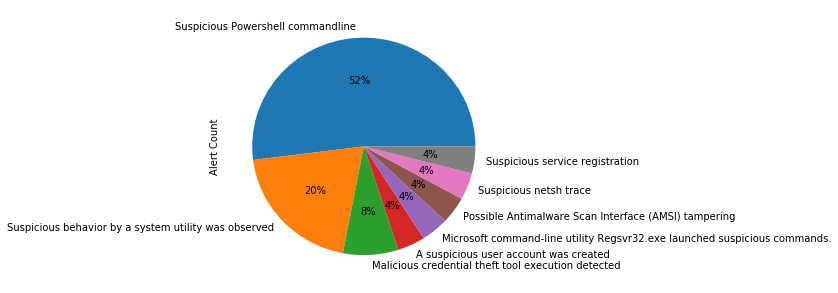

In [46]:
# show a quick pie chart using matplotlib
%matplotlib inline
plt = df1.plot.pie(y=0, figsize=(5, 5), legend=False, autopct='%1.0f%%')

## Querying machines
You can query machines by machine id, user id, ip, alert id, file sha1, domain, OData query, and more

In [47]:
wdatp_api.machines( machineid = 'c46e5570fbe248b00194c82a1a17541588b276fc')

@odata.context aadDeviceId  \
0  https://api.securitycenter.windows.com/api/$me...        None   

      agentVersion  computerDnsName                     firstSeen  \
0  10.5840.17763.1  desktop-jqlsi5j  2018-03-15T18:38:22.2435062Z   

  healthStatus                                        id  isAadJoined  \
0       Active  c46e5570fbe248b00194c82a1a17541588b276fc        False   

  lastExternalIpAddress    lastIpAddress                      lastSeen  \
0         104.42.20.124  192.168.137.101  2018-11-29T12:48:07.5768316Z   

  machineTags  osBuild osPlatform osVersion  rbacGroupId    rbacGroupName  \
0          []    17763  Windows10  10.0.0.0           72  avital test prd   

  riskScore  
0      High

In [48]:
# query machines associated with an alert
wdatp_api.machines( alertid = '636698715877028436_-1454424532')[['id', 'osBuild','osPlatform']]

id  osBuild osPlatform
0  4ba08007cb47ed0b9730b3460ea843a979cd90ce    18290  Windows10

In [49]:
# query machine by name
wdatp_api.machines( filterstr = "$filter=ComputerDnsName eq 'desktop-jqlsi5j'")

aadDeviceId     agentVersion  computerDnsName                     firstSeen  \
0        None  10.5840.17763.1  desktop-jqlsi5j  2018-03-15T18:38:22.2435062Z   

  healthStatus                                        id  isAadJoined  \
0       Active  c46e5570fbe248b00194c82a1a17541588b276fc        False   

  lastExternalIpAddress    lastIpAddress                      lastSeen  \
0         104.42.20.124  192.168.137.101  2018-11-29T12:48:07.5768316Z   

  machineTags  osBuild osPlatform osVersion  rbacGroupId    rbacGroupName  \
0          []    17763  Windows10  10.0.0.0           72  avital test prd   

  riskScore  
0      High

## Querying machine actions
You can query the actions that have been initiated against machines in WDATP.  You can query machines by Id, Status, MachineId, Type, Requestor and CreationDateTimeUtc

In [50]:
wdatp_api.machine_actions(filterstr = "$top=5&filter=Status eq 'Succeeded'&$select=creationDateTimeUtc,id,machineId,status,type")

creationDateTimeUtc                                    id  \
0  2018-11-30T20:32:54.3407439Z  28b0b0c2-acfd-4cb7-8c5f-37b5774d632b   
1  2018-11-30T20:32:53.0568627Z  aabe0556-d6a1-45e6-a0b7-c19dd4ae6164   
2  2018-11-30T20:32:51.8224634Z  9bff2220-6587-4412-96ae-1f5cccbecc15   
3  2018-11-30T20:32:50.4342921Z  2ed2fca9-6c66-4d64-979f-92cb132e902a   
4  2018-11-30T20:32:49.1999282Z  e77346b7-43c7-4f8f-a42a-aa687edd4dfb   

                                  machineId      status  \
0  109ee5bd252398b7c83b7122db44947c992f80e4        None   
1  51c74a0cd9caf8ee63ed2d3f81466b99a2c038fb   Succeeded   
2  25e322c874986fe85f9c4afc2b155c61fdf7f2c7  InProgress   
3  2d4276b6e81756bdb28de338ca612777d75dd00f   Succeeded   
4  b8cfddf97e14dfe6b1e4dc753cd32e833d6a481a   Succeeded   

                          type  
0  CollectInvestigationPackage  
1  CollectInvestigationPackage  
2  CollectInvestigationPackage  
3  CollectInvestigationPackage  
4  CollectInvestigationPackage

## Hunting
One of the most powerful things you can do with API is run hunting queries. This allows you to access 
the rich data that WDATP collects from endpoints. The following tables are exposed as part of Advanced hunting:

-  AlertEvents - Alerts on Windows Defender Security Center
-  MachineInfo - Machine information, including OS information
-  MachineNetworkInfo - Network properties of machines, including adapters, IP and MAC addresses, as well as connected networks and domains
-  ProcessCreationEvents - Process creation and related events
-  NetworkCommunicationEvents - Network connection and related events
-  FileCreationEvents - File creation, modification, and other file system events
-  RegistryEvents - Creation and modification of registry entries
-  LogonEvents - Login and other authentication events
-  ImageLoadEvents - DLL loading events
-  MiscEvents - Multiple event types, such as process injection, creation of scheduled tasks, and LSASS access attempts

In [51]:
## look for process creation events where someone ran:  net.exe user foo /domain

wdatp_api.query( query = '''
ProcessCreationEvents
| where EventTime > ago(3d)
| where FileName == 'net.exe'
| where ProcessCommandLine contains ' user ' and ProcessCommandLine contains ' /do' and ProcessCommandLine !contains ' /ad'
| project EventTime, ProcessCommandLine , InitiatingProcessCommandLine , InitiatingProcessParentFileName , AccountName 
| sort by InitiatingProcessParentFileName
''')

AccountName                     EventTime  \
0  administrator  2018-11-30T15:46:10.3661944Z   
1  administrator  2018-11-30T15:46:11.0601431Z   
2  administrator  2018-11-29T12:00:10.5473958Z   
3  administrator  2018-11-29T12:00:11.0519938Z   

                        InitiatingProcessCommandLine  \
0  cmd.exe /c "C:\MyTools\SimulateDetections\Wind...   
1  cmd.exe /c "C:\MyTools\SimulateDetections\Wind...   
2  cmd.exe /c "C:\Users\Administrator\Desktop\Sim...   
3  cmd.exe /c "C:\Users\Administrator\Desktop\Sim...   

  InitiatingProcessParentFileName       ProcessCommandLine  
0                     svchost.exe  net  user Bob1 /domain   
1                     svchost.exe  net  user BobX /domain   
2                     svchost.exe  net  user Bob1 /domain   
3                     svchost.exe  net  user BobX /domain

## Automate common steps

By scripting together commands you can start to automate common steps.

Let's query the most recent alert and then gather process creation records around the timeframe of the alert

In [52]:
#get the most recent alert
alert_df = wdatp_api.alerts(filterstr= '$top=1&$skip=10')

print("title: %s\ncategory: %s\nalert id: %s" % (alert_df.title.values[0], alert_df.category.values[0], alert_df.id.values[0]))

# build a hunting query that gets data around the time of the alert
get_records_qry = '''
let alertId = "%s";
let alert = AlertEvents | where AlertId == alertId | summarize AlertFirstEventTime=min(EventTime) by MachineId;
let machineId = toscalar(alert | project MachineId);
let timestamp = toscalar(alert | project AlertFirstEventTime);
let lookupPeriod = 10m;
find in (ProcessCreationEvents, NetworkCommunicationEvents, FileCreationEvents) 
where EventTime between ((timestamp - lookupPeriod) .. lookupPeriod)
        and MachineId == machineId
| project-away ComputerName, InitiatingProcessAccountDomain, InitiatingProcessAccountSid // demo env only
| take 1000
''' % (alert_df.id.values[0])

related_data_df = wdatp_api.query(query=get_records_qry)
print ("Number of records found %d" % len(related_data_df))
related_data_df 

title: Permissive ACL weakens overall system security
category: Persistence
alert id: 636790897753262340_843007043
Number of records found 235


ActionType AppGuardContainerId                     EventTime  \
0       FileCreated                       2018-11-29T12:00:01.802793Z   
1       FileCreated                      2018-11-29T12:00:02.9435967Z   
2      FileModified                      2018-11-29T12:00:03.0059329Z   
3       FileCreated                      2018-11-29T12:00:03.0059329Z   
4       FileCreated                      2018-11-29T12:00:02.9903021Z   
5       FileCreated                       2018-11-29T12:00:01.573237Z   
6       FileCreated                      2018-11-29T12:00:01.5528606Z   
7       FileCreated                       2018-11-29T12:00:01.573237Z   
8       FileCreated                      2018-11-29T12:00:03.0059329Z   
9       FileCreated                      2018-11-29T12:00:02.9590514Z   
10      FileCreated                       2018-11-29T12:00:01.573237Z   
11      FileCreated                      2018-11-29T12:00:01.5855211Z   
12      FileCreated                      2018-11-29T12:00:02.9746816Z   
13      FileCreated                      2018-11-29T12:00:01.6962427Z   
14      FileCreated                       2018-11-29T12:00:01.802793Z   
15      FileCreated                       2018-11-29T12:00:01.802793Z   
16      FileCreated                      2018-11-29T12:00:01.5528606Z   
17   ProcessCreated                      2018-11-29T12:00:00.5554854Z   
18   ProcessCreated                      2018-11-29T12:00:00.5705082Z   
19   ProcessCreated                       2018-11-29T12:00:00.775601Z   
20   ProcessCreated                      2018-11-29T12:00:00.8205578Z   
21   ProcessCreated                      2018-11-29T12:00:00.8667077Z   
22   ProcessCreated                      2018-11-29T12:00:00.9081495Z   
23   ProcessCreated                      2018-11-29T12:00:01.1878668Z   
24   ProcessCreated                       2018-11-29T12:00:02.597654Z   
25   ProcessCreated                      2018-11-29T12:00:02.7113689Z   
26   ProcessCreated                      2018-11-29T12:00:03.0359776Z   
27   ProcessCreated                      2018-11-29T12:00:03.2503162Z   
28   ProcessCreated                      2018-11-29T12:00:03.5472939Z   
29   ProcessCreated                      2018-11-29T12:00:03.6698866Z   
..              ...                 ...                           ...   
205  ProcessCreated                      2018-11-29T12:01:07.9293401Z   
206  ProcessCreated                      2018-11-29T12:01:08.0645677Z   
207  ProcessCreated                      2018-11-29T12:01:08.0993104Z   
208  ProcessCreated                      2018-11-29T12:01:08.3393736Z   
209  ProcessCreated                      2018-11-29T12:01:08.5524688Z   
210  ProcessCreated                      2018-11-29T12:01:08.7621612Z   
211  ProcessCreated                      2018-11-29T12:01:08.9938016Z   
212  ProcessCreated                      2018-11-29T12:01:09.0064814Z   
213  ProcessCreated                       2018-11-29T12:01:09.098033Z   
214  ProcessCreated                      2018-11-29T12:01:09.1322589Z   
215  ProcessCreated                      2018-11-29T12:01:09.1752755Z   
216  ProcessCreated                       2018-11-29T12:01:09.188792Z   
217  ProcessCreated                      2018-11-29T12:01:09.2870885Z   
218  ProcessCreated                      2018-11-29T12:01:09.3108931Z   
219  ProcessCreated                      2018-11-29T12:01:09.3949466Z   
220  ProcessCreated                      2018-11-29T12:01:09.4586071Z   
221  ProcessCreated                      2018-11-29T12:01:09.5221062Z   
222  ProcessCreated                      2018-11-29T12:01:09.7194881Z   
223  ProcessCreated                      2018-11-29T12:01:09.8792328Z   
224  ProcessCreated                      2018-11-29T12:01:10.0500407Z   
225  ProcessCreated                      2018-11-29T12:01:10.1985512Z   
226  ProcessCreated                      2018-11-29T12:01:10.3846446Z   
227  ProcessCreated                      2018-11-29T12:01:10.501873

## Saving results to a file

Pandas also has ways to easily save a data frame to a CSV, TSV, Excel, etc.  If you have Excel as a handler of tab delimited files, this should launch Excel

In [53]:
# save to TSV and launch
import os

filepath = os.environ.get('AppData') + '\\alert_data.tsv'

related_data_df.to_csv(filepath, sep='\t')

os.startfile(filepath)

## WDATP and Jupyter Magics

Lines starting with % signify a Jupyter magic. A "line magic" take the text after the command and does something with it. This notebook defines several magics to make it easier to access the data you need.

### Alert magic

`%wdatp_alert` takes an alert id and calls the API to get details about it

In [25]:
%wdatp_alert 636790987710443598_664996183

@odata.context  \
0  https://api.securitycenter.windows.com/api/$me...   

             alertCreationTime assignedTo     category classification  \
0  2018-11-29T14:32:50.700606Z       None  Persistence           None   

                                         description     detectionSource  \
0  A Managed Object Format (MOF) file was compile...  WindowsDefenderAtp   

  determination                firstEventTime                            id  \
0          None  2018-11-29T14:30:37.5433497Z  636790987710443598_664996183   

   incidentId    investigationState                 lastEventTime  \
0        7926  UnsupportedAlertType  2018-11-29T14:30:37.5433497Z   

                                  machineId  \
0  70fa0de59ee97660f15d02d94431c54cdab83490   

                                   recommendedAction resolvedTime severity  \
0  Investigate the machine timeline to determine ...         None   Medium   

  status threatFamilyName                                        title  
0    New             None  A MOF file was compiled to a remote machine

## Querying multiple alerts and regex
You can also provide a list of alert ids and invoke the cell magic with `%%wdatp_alert`

Because alert ids have a standard syntax, the alert magic also can take arbitrary text and it will extract alert ids
by using a regex.  This is handy if you want to quickly copy-paste some text from an email or chat window that has
alert ids intermixed with conversation.

In [26]:
%%wdatp_alert
Billy, be sure to investigate these 3 alerts and verify your results with Sue
636698715877028436_-1454424532
636705452714124042_1136763438
636790971221142208_-501438763
Please update the ticket when completed,
Thanks 
Alicia

@odata.context  \
0  https://api.securitycenter.windows.com/api/$me...   
0  https://api.securitycenter.windows.com/api/$me...   
0  https://api.securitycenter.windows.com/api/$me...   

              alertCreationTime assignedTo            category classification  \
0  2018-08-14T19:26:27.4528493Z       None         Persistence           None   
0  2018-08-22T14:34:31.2405008Z       None         Persistence           None   
0  2018-11-29T14:05:21.6610823Z       None  SuspiciousActivity           None   

                                         description     detectionSource  \
0  A system program was registered as a service. ...  WindowsDefenderAtp   
0  A system program was registered as a service. ...  WindowsDefenderAtp   
0  A suspicious behavior by a system utility was ...  WindowsDefenderAtp   

  determination                firstEventTime                              id  \
0          None   2018-08-13T20:31:06.239112Z  636698715877028436_-1454424532   
0          None  2018-08-22T14:33:04.4073986Z   636705452714124042_1136763438   
0          None  2018-11-29T06:59:35.0661428Z   636790971221142208_-501438763   

   incidentId    investigationState                 lastEventTime  \
0        1661  UnsupportedAlertType  2018-11-29T08:34:04.2921503Z   
0        2110  UnsupportedAlertType  2018-11-29T07:14:54.6843398Z   
0        7922  UnsupportedAlertType  2018-11-29T07:07:08.9902767Z   

                                  machineId  \
0  4ba08007cb47ed0b9730b3460ea843a979cd90ce   
0  80884f1c67675ae214faec3fc33652e1d2e9ad23   
0  c69ae95b5e28737d804e16485675d8adf61a64da   

                                   recommendedAction resolvedTime severity  \
0  A. Validate the alert and scope the suspected ...         None   Medium   
0  A. Validate the alert and scope the suspected ...         None   Medium   
0  1. Inspect processes and files in the executio...         None   Medium   

  status threatFamilyName                                              title  
0    New             None                    Suspicious service registration  
0    New             None                    Suspicious service registration  
0    New             None  Suspicious behavior by a system utility was ob...

### Machine magic
`%wdatp_machine` is the magic for a machine. You can pass in a machine id or hostname

In [36]:
%wdatp_machine ff650e5231004a86d0692d8b0e942bdd0c8e085f

@odata.context aadDeviceId  \
0  https://api.securitycenter.windows.com/api/$me...        None   

      agentVersion  computerDnsName                     firstSeen  \
0  10.5840.17756.1  desktop-5m6k86k  2018-10-12T08:25:59.4496124Z   

  healthStatus                                        id  isAadJoined  \
0       Active  ff650e5231004a86d0692d8b0e942bdd0c8e085f        False   

  lastExternalIpAddress  lastIpAddress                      lastSeen  \
0        167.220.196.78  10.166.175.78  2018-11-30T10:00:45.7939636Z   

  machineTags  osBuild osPlatform osVersion  rbacGroupId    rbacGroupName  \
0          []    17756  Windows10      None           72  avital test prd   

  riskScore  
0      High

In [37]:
%wdatp_machine desktop-5m6k86k

aadDeviceId     agentVersion  computerDnsName                     firstSeen  \
0        None  10.5840.17756.1  desktop-5m6k86k  2018-10-12T08:25:59.4496124Z   

  healthStatus                                        id  isAadJoined  \
0       Active  ff650e5231004a86d0692d8b0e942bdd0c8e085f        False   

  lastExternalIpAddress  lastIpAddress                      lastSeen  \
0        167.220.196.78  10.166.175.78  2018-11-30T10:00:45.7939636Z   

  machineTags  osBuild osPlatform osVersion  rbacGroupId    rbacGroupName  \
0          []    17756  Windows10      None           72  avital test prd   

  riskScore  
0      High

## Machine cell magic
You can also provide a list of machine ids or hostnames and invoke the cell magic with `%%wdatp_machine`

In [38]:
%%wdatp_machine 
desktop-5m6k86k
desktop-jqlsi5j
desktop-vn7j6e8

aadDeviceId        agentVersion  computerDnsName  \
0        None     10.5840.17756.1  desktop-5m6k86k   
0        None     10.5840.17763.1  desktop-jqlsi5j   
0        None  10.5810.17728.1000  desktop-vn7j6e8   

                      firstSeen healthStatus  \
0  2018-10-12T08:25:59.4496124Z       Active   
0  2018-03-15T18:38:22.2435062Z       Active   
0  2018-07-31T11:39:13.7979264Z       Active   

                                         id  isAadJoined  \
0  ff650e5231004a86d0692d8b0e942bdd0c8e085f        False   
0  c46e5570fbe248b00194c82a1a17541588b276fc        False   
0  c2b1722ec43f89c61f4f332e7b35ab183a2ef6d8         True   

  lastExternalIpAddress    lastIpAddress                      lastSeen  \
0        167.220.196.78    10.166.175.78  2018-11-30T10:00:45.7939636Z   
0         104.42.20.124  192.168.137.101  2018-11-29T12:48:07.5768316Z   
0          90.253.95.54       172.18.9.1   2018-11-29T16:28:01.025171Z   

  machineTags  osBuild osPlatform osVersion  rbacGroupId    rbacGroupName  \
0          []    17756  Windows10      None           72  avital test prd   
0          []    17763  Windows10  10.0.0.0           72  avital test prd   
0          []    17728  Windows10      None           72  avital test prd   

  riskScore  
0      High  
0      High  
0    Medium

In [39]:
%%wdatp_machine 
ff650e5231004a86d0692d8b0e942bdd0c8e085f
c46e5570fbe248b00194c82a1a17541588b276fc
c2b1722ec43f89c61f4f332e7b35ab183a2ef6d8

@odata.context aadDeviceId  \
0  https://api.securitycenter.windows.com/api/$me...        None   
0  https://api.securitycenter.windows.com/api/$me...        None   
0  https://api.securitycenter.windows.com/api/$me...        None   

         agentVersion  computerDnsName                     firstSeen  \
0     10.5840.17756.1  desktop-5m6k86k  2018-10-12T08:25:59.4496124Z   
0     10.5840.17763.1  desktop-jqlsi5j  2018-03-15T18:38:22.2435062Z   
0  10.5810.17728.1000  desktop-vn7j6e8  2018-07-31T11:39:13.7979264Z   

  healthStatus                                        id  isAadJoined  \
0       Active  ff650e5231004a86d0692d8b0e942bdd0c8e085f        False   
0       Active  c46e5570fbe248b00194c82a1a17541588b276fc        False   
0       Active  c2b1722ec43f89c61f4f332e7b35ab183a2ef6d8         True   

  lastExternalIpAddress    lastIpAddress                      lastSeen  \
0        167.220.196.78    10.166.175.78  2018-11-30T10:00:45.7939636Z   
0         104.42.20.124  192.168.137.101  2018-11-29T12:48:07.5768316Z   
0          90.253.95.54       172.18.9.1   2018-11-29T16:28:01.025171Z   

  machineTags  osBuild osPlatform osVersion  rbacGroupId    rbacGroupName  \
0          []    17756  Windows10      None           72  avital test prd   
0          []    17763  Windows10  10.0.0.0           72  avital test prd   
0          []    17728  Windows10      None           72  avital test prd   

  riskScore  
0      High  
0      High  
0    Medium

In [40]:
# here is how to invoke the API and provide an OData query
wdatp_api.machines(filterstr = "$select=id,osBuild,osPlatform&$filter=startswith(computerDnsName,'desktop')&$top=5")

id  osBuild osPlatform
0  f707abf3027cf0a698ee50bd04335927f1369aa2    17134  Windows10
1  ecbe1d69a9941035cfb50d4209a95b67cb941d74    18292  Windows10
2  ccffe8d0c7597a82f57b951247bac173cec98833    17704  Windows10
3  ff650e5231004a86d0692d8b0e942bdd0c8e085f    17756  Windows10
4  057d9247af2631f8d1f5f92a18ba682d22f89243    18292  Windows10

In [41]:
# let's look up a specific host
wdatp_api.machines(filterstr = "$filter=ComputerDnsName eq 'desktop-vn7j6e8'")

aadDeviceId        agentVersion  computerDnsName  \
0        None  10.5810.17728.1000  desktop-vn7j6e8   

                      firstSeen healthStatus  \
0  2018-07-31T11:39:13.7979264Z       Active   

                                         id  isAadJoined  \
0  c2b1722ec43f89c61f4f332e7b35ab183a2ef6d8         True   

  lastExternalIpAddress lastIpAddress                     lastSeen  \
0          90.253.95.54    172.18.9.1  2018-11-29T16:28:01.025171Z   

  machineTags  osBuild osPlatform osVersion  rbacGroupId    rbacGroupName  \
0          []    17728  Windows10      None           72  avital test prd   

  riskScore  
0    Medium

In [42]:
# Let's look up machines with a High risk score
wdatp_api.machines(filterstr="$select=id,RiskScore&$top=5&$filter=riskScore eq 'High'")

id riskScore
0  80102a08edaa9e2aa875abb5d787db5064cc5246      High
1  b8cfddf97e14dfe6b1e4dc753cd32e833d6a481a      High
2  13a841485e2daecc7ae3ba6b70449ebaac5355b0      High
3  ff650e5231004a86d0692d8b0e942bdd0c8e085f      High
4  80884f1c67675ae214faec3fc33652e1d2e9ad23      High

### Magic for IPs
You can look up WDATP data on IPs with the` %%wdatp_ip` magic 

In [43]:
%%wdatp_ip  
52.239.151.138
65.52.108.90

@odata.context       ipAddress  \
0  https://api.securitycenter.windows.com/api/$me...  52.239.151.138   
0  https://api.securitycenter.windows.com/api/$me...    65.52.108.90   

           orgFirstSeen           orgLastSeen orgPrevalence  
0  2018-10-31T21:31:06Z  2018-11-30T19:58:08Z           236  
0  2018-10-31T21:33:18Z  2018-11-30T21:06:09Z          3868

### Magic for files
You can look up WDATP data on files with the `%%wdatp_file` magic 

In [44]:
%%wdatp_file
638b2e1faad40472326dd4c52a1761f14136b6a8
4b3f13e136acd1a112a75fa5179c2e2018598364

@odata.context fileProductName  \
0  https://api.securitycenter.windows.com/api/$me...            None   
0  https://api.securitycenter.windows.com/api/$me...            None   

  filePublisher fileType           globalFirstObserved  \
0          None    NonPE  2018-06-19T20:12:53.8165192Z   
0          None  Unknown  2015-05-08T09:00:04.1338588Z   

             globalLastObserved  globalPrevalence  isPeFile  \
0  2018-11-30T08:45:39.2491437Z            352192     False   
0  2018-11-30T08:43:23.9550783Z           1900485     False   

  isValidCertificate issuer                               md5  \
0               None   None  39fe884338fdb988b679c653d3ba0651   
0               None   None  af1d6460de40997a55e5a1c373ece3b5   

                                       sha1  \
0  638b2e1faad40472326dd4c52a1761f14136b6a8   
0  4b3f13e136acd1a112a75fa5179c2e2018598364   

                                              sha256 signer signerHash   size  \
0  7d2ddee494f1a5bd2be8d1bca2b0495a488e3bfd2abaeb...   None       None  12314   
0  6486d456ff41f4039405318f10b35995415b9452f9d4d0...   None       None   2571   

  windowsDefenderAVThreatName  
0                        None  
0                        None

### Magic for machine actions
You can look up WDATP data on machine actions with the `%%wdatp_action` magic. As in previous examples, this magic will regex for the GUIDs used to identify actions

In [45]:
%%wdatp_action
Kindly look at the following actions
845960bf-6148-4151-9c66-d88eeca5e7aa
ae819b45-f343-44dd-9e11-c6d0b2cad565
b7ec6e6f-b984-4058-ab95-d59a369e1a6c
Thanks

@odata.context  \
0  https://api.securitycenter.windows.com/api/$me...   
0  https://api.securitycenter.windows.com/api/$me...   
0  https://api.securitycenter.windows.com/api/$me...   

            creationDateTimeUtc                                    id  \
0  2018-11-29T14:33:17.7365757Z  845960bf-6148-4151-9c66-d88eeca5e7aa   
0   2018-11-29T14:33:16.467889Z  ae819b45-f343-44dd-9e11-c6d0b2cad565   
0  2018-11-29T14:33:14.5515192Z  b7ec6e6f-b984-4058-ab95-d59a369e1a6c   

          lastUpdateDateTimeUtc                                 machineId  \
0  2018-11-29T14:36:01.9592049Z  c8ea7f9c281f0c8e888e6d4cf9672593c0865c2d   
0  2018-11-29T14:34:10.0872311Z  51c74a0cd9caf8ee63ed2d3f81466b99a2c038fb   
0   2018-11-29T14:36:54.113849Z  9b2153d0c675eaa415b8e5f383c6388bff446c62   

  relatedFileInfo                           requestor  \
0            None  Analyst@WcdTestPrd.onmicrosoft.com   
0            None  Analyst@WcdTestPrd.onmicrosoft.com   
0            None  Analyst@WcdTestPrd.onmicrosoft.com   

                                    requestorComment     status  \
0  Forensic Collection test automation - AutoIR o...  Succeeded   
0  Forensic Collection test automation - AutoIR o...     Failed   
0  Forensic Collection test automation - AutoIR o...  Succeeded   

                          type  
0  CollectInvestigationPackage  
0  CollectInvestigationPackage  
0  CollectInvestigationPackage

## Visualize WDATP data with Holoviews

Holoviews is an open source visualization library for Python. In this example we select a set of machines (desktops and servers)
and get a list of the netblocks they are communicating with.  We render the data in a Chord diagram. This makes it easy to see
the flows of information and quickly grasp who is talking to whom.

This kind of visualization can be useful to plot the communication patterns of a set of machines that should be fairly similar 
(Domain controllers, databases, HR servers) and quickly see outliers

rows returned = 49


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
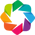

:Chord   [source,dest]

In [46]:
# this query gets a handful of machines named desktop 
query = '''
let machine_list = MachineInfo | where EventTime > ago(1d) | where ComputerName startswith 'desktop-' | summarize by ComputerName, MachineId | take 5;
NetworkCommunicationEvents
| where EventTime > ago(5d) | where isnotempty(MachineId)
| where RemoteIPType == 'Public' and RemoteIP contains ('.') and RemotePort in ('80') 
| extend MaskedIP = strcat(split(RemoteIP,'.')[0],'.', split(RemoteIP,'.')[1], '.*.*')
| summarize by MachineId, MaskedIP 
| join kind=inner (machine_list) on MachineId 
| summarize by ComputerName, MaskedIP
'''
df = wdatp_api.query(query)
print ("rows returned = %d" % len(df))

## this does some footwork for holoviews to allow us to format the colors, nodes, and edges.

import holoviews as hv
hv.extension('bokeh')

def holoview_charting_objects(df):
    g1 = list(df[df.columns[0]].astype(str).unique())
    g2 = list(df[df.columns[1]].astype(str).unique())
    g1d = list(map(lambda x: {'name': x, 'group':1}, g1))
    g2d = list(map(lambda x: {'name': x, 'group':2}, g2))
    nodes = hv.Dataset(pd.DataFrame(g1d + g2d), 'index')

    src = list(map(lambda x: nodes.data[nodes.data['name'] == x]['index'].values[0], list(df[df.columns[0]].values)))
    dst = list(map(lambda x: nodes.data[nodes.data['name'] == x]['index'].values[0], list(df[df.columns[1]].values)))
    df2 = pd.DataFrame(list(zip(src,dst)), columns=['source','dest'])
    return (df2, nodes)

%opts Chord [width=800 height=800]
%opts Chord [label_index='name' color_index='index' edge_color_index='source'] 
%opts Chord (cmap='Category20' edge_cmap='Category20')

import holoviews as hv
hv.Chord(holoview_charting_objects(df))

## Rendering in a scatter plot

Holoviews supports many different kinds of visualization options.  Give them a try!

Here is another way to view the same data.  This uses a scatter plot. Each row is an IP grouping and 
if the machine has communicated to it, you will see a dot.  If a row has only one dot, that means only
one machine communicated to it. You can easily can the scatter plot to find outliers.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
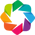

:Scatter   [ComputerName]   (MaskedIP)

In [47]:
# we can also render the same data in a Scatter plot

%opts Scatter [width=800 height=800] (size=10)
import holoviews as hv
hv.extension('bokeh')
hv.Scatter(df).options(show_grid=True)

## Enriching results by calling 3rd party APIs: VirusTotal
Now we'll do an example of combining WDATP data with information from other sources, in this case VirusTotal.  
We'll do a search to find file hashes and see if VirusTotal has any information on them

In [20]:
## query WDATP data for hashes of files recorded in alerts

df_results = wdatp_api.query(query = '''
AlertEvents 
| where EventTime > ago(7d) and SHA1 != ''
| summarize by SHA1
| take 100
'''
)
print("Number of hashes = %d" % len(df_results))

Number of hashes = 100


In [21]:
## query VirusTotal to see if anyone has submitted them for scanning before. 
## List any results with at least one AV engine positive result

vtdf = wdatp_api.vtresults(list(df_results.SHA1)).fillna('')
vt_pos = vtdf.loc[vtdf['response_code'] == 1].loc[vtdf['positives'] != 0]
vt_pos.head(5)

md5  \
36  b5962945811f8d275a3a69334dbc81e8   
70  44d88612fea8a8f36de82e1278abb02f   
87  e0354fa01f29dc47ab6d49956c49a128   
88  9bd28300d67ff40e18a3bae80232eea1   
89  8651cb193fb0c9052cc4c39ecb849a90   

                                            permalink positives  \
36  https://www.virustotal.com/file/d81da8c83776c6...        47   
70  https://www.virustotal.com/file/275a021bbfb648...        59   
87  https://www.virustotal.com/file/24abab4054bda1...        24   
88  https://www.virustotal.com/file/5e001d47b541c3...        30   
89  https://www.virustotal.com/file/7d52a7a759179f...        48   

                                    resource  response_code  \
36  d40a48094c1f21fef892f27a8b6a7ed2bbf0c27f              1   
70  3395856ce81f2b7382dee72602f798b642f14140              1   
87  b40c04604bf3bbee92fd70beeaefabaa7e92206a              1   
88  bed5b5f463d0c9aee190c2d6490d8d33b9d1dd30              1   
89  5741705f5a37470c6880130d74822f805078af5e              1   

              scan_date                                            scan_id  \
36  2018-12-01 06:33:18  d81da8c83776c60df5cc533e5d54c780a413649cdcc65c...   
70  2018-12-04 00:11:33  275a021bbfb6489e54d471899f7db9d1663fc695ec2fe2...   
87  2018-11-09 11:09:23  24abab4054bda1b846b012f71dd0687b4fd4069afc5fda...   
88  2018-11-09 11:09:20  5e001d47b541c301b292f555554f060dc18cf19cc28bd3...   
89  2018-10-31 11:00:35  7d52a7a759179f2678458c190a30fe630d770ee8676815...   

   scans.ALYac.detected         scans.ALYac.result scans.ALYac.update  \
36                False                                      20181201   
70                 True       Misc.Eicar-Test-File           20181203   
87                False                                      20181109   
88                 True  Trojan.GenericKD.30880848           20181109   
89                False                                      20181031   

                   ...                  scans.eGambit.update  \
36                 ...                              20181201   
70                 ...                                         
87                 ...                                         
88                 ...                                         
89                 ...                              20181031   

   scans.eGambit.version scans.nProtect.detected scans.nProtect.result  \
36                v4.3.5                                                 
70                                                                       
87                                                                       
88                                                                       
89                                                                       

   scans.nProtect.update scans.nProtect.version  \
36                                                
70                                                
87                                                
88                                                
89                                                

                                        sha1  \
36  d40a48094c1f21fef892f27a8b6a7ed2bbf0c27f   
70  3395856ce81f2b7382dee72602f798b642f14140   
87  b40c04604bf3bbee92fd70beeaefabaa7e92206a   
88  bed5b5f463d0c9aee190c2d6490d8d33b9d1dd30   
89  5741705f5a37470c6880130d74822f805078af5e   

                                               sha256 total  \
36  d81da8c83776c60df5cc533e5d54c780a413649cdcc65c...    68   
70  275a021bbfb6489e54d471899f7db9d1663fc695ec2fe2...    61   
87  24abab4054bda1b846b012f71dd0687b4fd4069afc5fda...    66   
88  5e001d47b541c301b292f555554f060dc18cf19cc28bd3...    65   
89  7d52a7a759179f2678458c190a30fe630d770ee8676815...    67   

                            verbose_msg  
36  Scan finished, information embedded  
70  Scan finished, information embedded  
87  Scan finished, information embedded  
88  Scan finished, information embedded  
89  Scan finished, information embedded  

[5 rows x 307 columns]

In [22]:
## look up each positive hit in WDATP data and enrich results with WDATP information

wdatp_file_results = []
df_all = pd.DataFrame()
for sha1 in list(vt_pos['sha1']):
    df_file = wdatp_api.files(filehash = sha1)
    if len(df_file) > 0:
        wdatp_file_results.append(df_file)
if len(wdatp_file_results) > 0:
    df_all = pd.concat(wdatp_file_results)
df_all = df_all.merge(vt_pos, right_on = 'sha1', left_on = 'sha1')
df_all

@odata.context  \
0   https://api.securitycenter.windows.com/api/$me...   
1   https://api.securitycenter.windows.com/api/$me...   
2   https://api.securitycenter.windows.com/api/$me...   
3   https://api.securitycenter.windows.com/api/$me...   
4   https://api.securitycenter.windows.com/api/$me...   
5   https://api.securitycenter.windows.com/api/$me...   
6   https://api.securitycenter.windows.com/api/$me...   
7   https://api.securitycenter.windows.com/api/$me...   
8   https://api.securitycenter.windows.com/api/$me...   
9   https://api.securitycenter.windows.com/api/$me...   
10  https://api.securitycenter.windows.com/api/$me...   
11  https://api.securitycenter.windows.com/api/$me...   
12  https://api.securitycenter.windows.com/api/$me...   
13  https://api.securitycenter.windows.com/api/$me...   
14  https://api.securitycenter.windows.com/api/$me...   

                                      fileProductName  \
0                                            mimikatz   
1   Odysseus                                      ...   
2                                                None   
3                                                None   
4                                                None   
5                                                None   
6                                                None   
7                                                None   
8                                                None   
9                                                None   
10                                               None   
11                               Metasploit Framework   
12               MicrosoftÂ® WindowsÂ® Operating System   
13                                               None   
14                                               None   

                                        filePublisher            fileType  \
0                         gentilkiwi (Benjamin DELPY)                 APP   
1   BeginFinite                                   ...                 APP   
2                                                None  PortableExecutable   
3                                                None  PortableExecutable   
4                                                None  PortableExecutable   
5                                                None  PortableExecutable   
6                                                None  PortableExecutable   
7                                                None  PortableExecutable   
8                                                None  PortableExecutable   
9                                                None  PortableExecutable   
10                                               None             Unknown   
11                                         Rapid7 LLC                 APP   
12                              Microsoft Corporation                 DLL   
13                                               None             Unknown   
14                                               None             Unknown   

             globalFirstObserved            globalLastObserved  \
0   2018-09-25T22:34:38.9566202Z  2018-12-03T16:10:22.1433986Z   
1   2013-03-03T14:00:34.8213548Z  2018-12-03T16:57:29.3516922Z   
2   2014-06-21T17:41:28.7487764Z  2018-12-03T16:49:45.0301875Z   
3   2017-10-19T13:31:48.8066496Z  2018-12-03T16:49:45.0301875Z   
4   2014-04-12T18:31:37.1432546Z  2018-12-03T16:49:45.0301875Z   
5   2014-03-30T13:52:41.5376917Z  2018-12-03T16:49:45.0301875Z   
6   2013-12-13T00:22:58.2227398Z  2018-12-03T16:49:45.0301875Z   
7   2014-11-05T09:31:08.2270885Z  2018-12-03T16:49:45.0301875Z   
8   2014-01-17T04:21:54.9439502Z  2018-12-03T16:49:45.0301875Z   
9   2015-06-25T14:35:00.4102258Z  2018-12-03T16:49:45.0301875Z   
10  2013-03-03T14:00:34.8213548Z  2018-12-03T16:45:05.6407522Z   
11  2013-03-03T14:00:34.8213548Z  2018-12-03T16:45:05.6407522Z   
12  2013-03-03T14:00:34.8213548Z  2018-12-03T16:45:05.6407522Z   
13  2013-03-03T15:06:59.3469274Z  2018-12-03T16:45:05.

In [23]:
# show merged data from WDATP and VirusTotal for the top entry
df_all.head(1).T

0
@odata.context               https://api.securitycenter.windows.com/api/$me...
fileProductName                                                       mimikatz
filePublisher                                      gentilkiwi (Benjamin DELPY)
fileType                                                                   APP
globalFirstObserved                               2018-09-25T22:34:38.9566202Z
globalLastObserved                                2018-12-03T16:10:22.1433986Z
globalPrevalence                                                          4435
isPeFile                                                                  True
isValidCertificate                                                        True
issuer                                             Certum Code Signing CA SHA2
md5_x                                         b5962945811f8d275a3a69334dbc81e8
sha1                                  d40a48094c1f21fef892f27a8b6a7ed2bbf0c27f
sha256_x                     d81da8c83776c60df5cc533e5d54c780a413649cdcc65c...
signer                                   Open Source Developer, Benjamin Delpy
signerHash                            9431a67881c152112500e1bc89d4d37fd808dd71
size                                                                      None
windowsDefenderAVThreatName                                               None
md5_y                                         b5962945811f8d275a3a69334dbc81e8
permalink                    https://www.virustotal.com/file/d81da8c83776c6...
positives                                                                   47
resource                              d40a48094c1f21fef892f27a8b6a7ed2bbf0c27f
response_code                                                                1
scan_date                                                  2018-12-01 06:33:18
scan_id                      d81da8c83776c60df5cc533e5d54c780a413649cdcc65c...
scans.ALYac.detected                                                     False
scans.ALYac.result                                                            
scans.ALYac.update                                                    20181201
scans.ALYac.version                                                    1.1.1.5
scans.AVG.detected                                                        True
scans.AVG.result                                          FileRepMalware [PUP]
...                                                                        ...
scans.WhiteArmor.result                                                       
scans.WhiteArmor.update                                                       
scans.WhiteArmor.version                                                      
scans.Yandex.detected                                                    False
scans.Yandex.result                                                           
scans.Yandex.update                                                   20181130
scans.Yandex.version                                                   5.5.1.3
scans.Zillya.detected                                                     True
scans.Zillya.result                                    Tool.Mimikatz.Win64.442
scans.Zillya.update                                                   20181130
scans.Zillya.version                                                2.0.0.3704
scans.ZoneAlarm.detected                                                  True
scans.ZoneAlarm.result                      HEUR:Trojan-PSW.Win64.Mimikatz.gen
scans.ZoneAlarm.update                                                20181201
scans.ZoneAlarm.version                                                    1.0
scans.Zoner.detected                                                     False
scans.Zoner.result                                                            
scans.Zoner.update                                                    20181201
scans.Zoner.version                                                        1.0
scans.eGambit.detected                          